# The VDDG model forced by the Jin-Timmermann ENSO model

## Preamble

This notebook comes as a supplementary material to the article

* Vannitsem, S., Demaeyer, J. and Ghil, M. (2021). Extratropical low-frequency variability with ENSO forcing: A reduced-order coupled model study. *Submitted to JAMES.* [arxiv.org/abs/2103.00517](https://arxiv.org/abs/2103.00517).

and details the code of the model used to perform the computations needed to obtain the results therein.

It consists of the [qgs model](https://github.com/Climdyn/qgs) in the MAOOAM-VDDG configuration to model the extra-tropics, and forced by the Jin-Timmerman model which models ENSO. More information on the components can be found in the articles:

* Vannitsem, S., Demaeyer, J., De Cruz, L., & Ghil, M. (2015). Low-frequency variability and heat transport in a low-order nonlinear coupled ocean–atmosphere model. *Physica D: Nonlinear Phenomena*, **309**, 71-85. [doi:10.1016/j.physd.2015.07.006](https://doi.org/10.1016/j.physd.2015.07.006)
* De Cruz, L., Demaeyer, J. and Vannitsem, S. (2016). The Modular Arbitrary-Order Ocean-Atmosphere Model: MAOOAM v1.0, *Geosci. Model Dev.*, **9**, 2793-2808. [doi:10.5194/gmd-9-2793-2016](https://doi.org/10.5194/gmd-9-2793-2016)
* Demaeyer J., De Cruz, L. and Vannitsem, S. , (2020). qgs: A flexible Python framework of reduced-order multiscale climate models. *Journal of Open Source Software*, **5**(56), 2597, [doi:10.21105/joss.02597](https://doi.org/10.21105/joss.02597).
* Timmermann, A., Jin, F. F., & Abshagen, J. (2003). A nonlinear theory for El Niño bursting. *Journal of the atmospheric sciences*, **60**(1), 152-165, [doi:10.1175/1520-0469(2003)060%3C0152:ANTFEN%3E2.0.CO;2](https://doi.org/10.1175/1520-0469(2003)060%3C0152:ANTFEN%3E2.0.CO;2).
* Roberts, A., Guckenheimer, J., Widiasih, E., Timmermann, A., & Jones, C. K. (2016). Mixed-mode oscillations of El Nino–southern oscillation. *Journal of Atmospheric Sciences*, **73**(4), 1755-1766, [doi:10.1175/JAS-D-15-0191.1](https://doi.org/10.1175/JAS-D-15-0191.1).


In this notebook, we define the forced model and integrate it to get several trajectories.





## Requirements

The present notebook was tested on a computer with

    12 recent cpu cores,
    16 Gb of RAM,

the whole computation during about less than an hour. About 9 Gb of RAM space are also used to store the data of the model's trajectories.



## Installation

To install this notebook, you must first [install the qgs model](https://qgs.readthedocs.io/en/latest/files/general_information.html#installation) and test that it works properly on your machine. Follow the instructions in the model documentation. Then you must move the present notebook in the notebooks directory and run it with jupyter-notebook. In the qgs model main folder, do:

    conda activate qgs
    cd notebooks
    jupyter-notebook

It will open a page in a web browser where you can open and then run the present notebook.

We now proceed to the code itself:


## Modules import

First, setting of the path and loading of some modules

In [1]:
import sys, os

In [2]:
sys.path.extend([os.path.abspath('../')])

In [3]:
import numpy as np
from numba import njit
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

Initializing the random number generator (for reproducibility). -- Disable if needed.

In [4]:
np.random.seed(210217)

Importing the model's modules

In [5]:
from params.params import QgParams
from integrators.integrator import RungeKuttaIntegrator
from functions.tendencies import create_tendencies

## Systems definition

General parameters

In [6]:
# Time step parameters
dt = 0.1
# Saving the model state n steps
write_steps = 100

number_of_trajectories = 2

### VDDG (using qgs)

Setting some model parameters

In [7]:
# Model parameters instantiation
model_parameters = QgParams()

## VDDG model selection:
# Mode truncation at the wavenumber 2 in both x and y spatial
# coordinates for the atmosphere
model_parameters.set_atmospheric_channel_fourier_modes(2, 2)
# Mode truncation at the wavenumber 2 in the x and at the 
# wavenumber 4 in the y spatial coordinates for the ocean
model_parameters.set_oceanic_basin_fourier_modes(2, 4)

In [8]:
# Setting MAOOAM parameters according to the publication
model_parameters.set_params({'kd': 0.0290, 'kdp': 0.0290, 'n': 1.5, 'r': 1.e-7,
                             'h': 100.0, 'd': 1.5e-7, 'time_unit': 'years'})
model_parameters.atemperature_params.set_params({'hlambda': 15.06})
model_parameters.gotemperature_params.set_params({'gamma': 4.0e8})

Setting the short-wave radiation component $C_{\text{a},1}$ and $C_{\text{o},1}$ as in the publication:


In [9]:
model_parameters.atemperature_params.set_insolation(310./4, 0)
model_parameters.gotemperature_params.set_insolation(310, 0)

Printing the VDDG model's parameters

In [10]:
model_parameters.print_params()

Qgs parameters summary

General Parameters:
'time_unit': years,
'rr': 287.058  [J][kg^-1][K^-1]  (gas constant of dry air),
'sb': 5.67e-08  [J][m^-2][s^-1][K^-4]  (Stefan-Boltzmann constant),

Scale Parameters:
'scale': 5000000.0  [m]  (characteristic space scale (L*pi)),
'f0': 0.0001032  [s^-1]  (Coriolis parameter at the middle of the domain),
'n': 1.5    (aspect ratio (n = 2 L_y / L_x)),
'rra': 6370000.0  [m]  (earth radius),
'phi0_npi': 0.25    (latitude expressed in fraction of pi),
'deltap': 50000.0  [Pa]  (pressure difference between the two atmospheric layers),

Atmospheric Parameters:
'kd': 0.029  [nondim]  (atmosphere bottom friction coefficient),
'kdp': 0.029  [nondim]  (atmosphere internal friction coefficient),
'sigma': 0.2  [nondim]  (static stability of the atmosphere),

Atmospheric Temperature Parameters:
'gamma': 10000000.0  [J][m^-2][K^-1]  (specific heat capacity of the atmosphere),
'C[1]': 77.5  [W][m^-2]  (spectral component 1 of the short-wave radiation of the atm

Creating the VDDG (qgs) tendencies function

In [11]:
%%time
f_vddg, Df_vddg = create_tendencies(model_parameters)

CPU times: user 5.03 s, sys: 62.9 ms, total: 5.1 s
Wall time: 3.05 s


### Jin-Timmermann ENSO model

The nondimensional equations governing the ENSO module are given by:       
$
\begin{align}
\frac{dx}{dt} = & \, \rho \delta (x^2-a x) + s x (x+y+c-c \tanh(x+z)), \\
\frac{dy}{dt} = & \, -\rho \delta (a y+x^2), \\
\frac{dz}{dt} = & \, \delta (k-z-\frac{x}{2}).
\end{align}
$



Here $x, y, z$ and $t$ are dimensionless, $x$ is the temperature difference between the eastern and western basins of the Tropical Pacific, $y$ the western basin's temperature anomaly with respect to a reference value, and $z$ the western basin's thermocline depth anomaly.


Setting first some model parameters

In [12]:
# Periodic solutions
#delta = 0.00028058
#rho = 0.3224
#c = 2.3952
#k = 0.4032
#a = 6.8927
#s = 0.0010691

# Chaotic solutions
delta = 0.0002803
rho = 0.29016
c = 2.3952
k = 0.4032
a = 7.658609809
s = 0.001069075

Creating the tendencies function using a [Numba](https://numba.pydata.org/) jitted function

In [13]:
@njit
def f_JT(t, x):
    dxdt = rho * delta * (x[0]**2 - a * x[0]) + s * x[0] * (x[0] + x[1] + c - c * np.tanh(x[2] + x[0]))
    dydt = -rho * delta * (a * x[1] + x[0]**2)
    dzdt = delta * (k - x[2] - x[0] / 2)

    return np.array([dxdt, dydt, dzdt])



#### Integrating the ENSO model to get averages

Defining an integrator

In [14]:
integrator = RungeKuttaIntegrator()
integrator.set_func(f_JT)

First initial conditions for the ENSO model

In [15]:
ic_enso = np.array([-2.8439, -0.62, 1.48])

In [16]:
%%time
integrator.integrate(0., 10000000., dt, ic=ic_enso, write_steps=write_steps)
time, traj = integrator.get_trajectories()
# new initial condition
ic_enso = traj[:,-1]
# average
mean_enso = np.mean(traj, axis=-1)

CPU times: user 239 ms, sys: 527 ms, total: 766 ms
Wall time: 1min 48s


### Forced VDDG-ENSO model

The forced VDDG-ENSO model is obtained by modifying the tendency $f_1$ of the first component $\psi_{{\rm a}, 1}$ of the atmospheric streamfunction of VDDG: 

$$
\frac{\mathrm{d}\psi_{{\rm a},1}}{\mathrm{d}t} = f_1(\psi_{{\rm a}, 1}, \theta_{{\rm a}, 1}) + g\, (x+y)'.
$$

where the parameter $g$ scales the intensity of the tropical forcing. The variable $(x + y)'$ is the Tropical eastern basin temperature anomaly of the ENSO model.

To simplify the integration, the full system of equations is constructed by concatenating together the equations of motion of both models, to give:
$$
\frac{\mathrm{d}\boldsymbol{X}}{\mathrm{d}t} = \boldsymbol{F}(\boldsymbol{X})
$$

Hence, we first set the coupling parameters:

In [17]:
g = 0.03
enso_temperature_scaling = 2.8182
ndim = model_parameters.ndim
vddg_temperature_scaling = (model_parameters.scale_params.L * model_parameters.scale_params.f0)**2 / model_parameters.rr
enso_to_vddg_temperature_scaling = enso_temperature_scaling / vddg_temperature_scaling
mean_east_basin_enso = mean_enso[0] + mean_enso[1]

and then create the tendencies function of the full system using a [Numba](https://numba.pydata.org/) jitted function:

In [18]:
@njit
def f_forced(t, x):
    tend_vddg = f_vddg(t, x[:ndim])
    tend_JT = f_JT(t, x[ndim:])
    tend_vddg[0] = tend_vddg[0] + g * enso_to_vddg_temperature_scaling * ((x[ndim] + x[ndim+1]) - mean_east_basin_enso)
    return np.concatenate((tend_vddg, tend_JT))

**The function** `f_forced` **hence defined is the tendencies** $\boldsymbol{F}(\boldsymbol{X})$ **of the ENSO forced VDDG model used in the publication above.**

## Time integration

#### Integrating the forced model

Start random initial conditions for the VDDG model and integrate over a transient time to obtain initial conditions on the attractor(s)

In [19]:
%%time
## Reuse the integrator
integrator.set_func(f_forced)

## Might take several minutes, depending on your cpu computational power.
ic = np.random.rand(number_of_trajectories, model_parameters.ndim+3)*0.1
ic[:, ndim:] = ic_enso + np.zeros((number_of_trajectories, 3))
# Integration loop (to integrate a very long time)
for i in range(10):
    integrator.integrate(0., 1000000., dt, ic=ic, write_steps=0)
    time, ic = integrator.get_trajectories()

CPU times: user 413 ms, sys: 1.13 s, total: 1.54 s
Wall time: 8min 48s


Now integrate to obtain trajectories on the attractor(s)

In [20]:
%%time
integrator.integrate(0., 1000000., dt, ic=ic, write_steps=write_steps)
time, traj = integrator.get_trajectories()

# Integration loop (to integrate a very long time)
for i in range(49):
    integrator.integrate(time[-1], time[-1]+1000000., dt, ic=traj[...,-1], write_steps=write_steps)
    time_new, traj_new = integrator.get_trajectories()
    time = np.concatenate((time, time_new[1:]))
    traj = np.concatenate((traj, traj_new[..., 1:]), axis=-1)


CPU times: user 7.4 s, sys: 17.2 s, total: 24.6 s
Wall time: 43min 35s


#### Plotting the result of the integration in 3D and 2D

3D plot of the variables $\psi_{{\rm o}, 2}$, $\theta_{{\rm o}, 2}$ and $\psi_{{\rm a}, 1}$ of the first trajectory

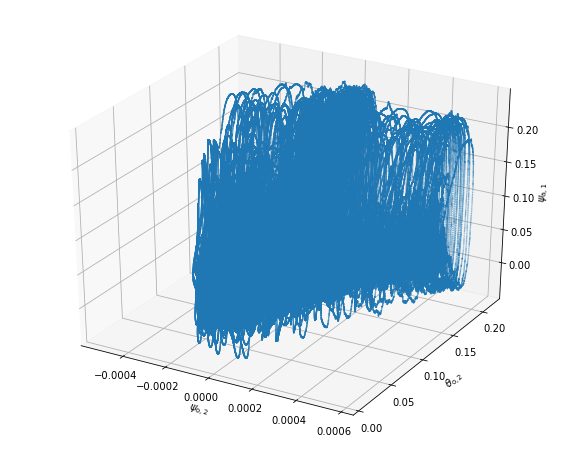

In [21]:
varx = 21
vary = 29
varz = 0

fig = plt.figure(figsize=(10, 8))
axi = plt.axes(projection='3d')

axi.scatter(traj[0, varx], traj[0, vary], traj[0, varz], s=0.2);

axi.set_xlabel('$'+model_parameters.latex_var_string[varx]+'$')
axi.set_ylabel('$'+model_parameters.latex_var_string[vary]+'$')
axi.set_zlabel('$'+model_parameters.latex_var_string[varz]+'$');

2D plot of the variables $\psi_{{\rm o}, 2}$ and $\theta_{{\rm o}, 2}$ of the first and second trajectories

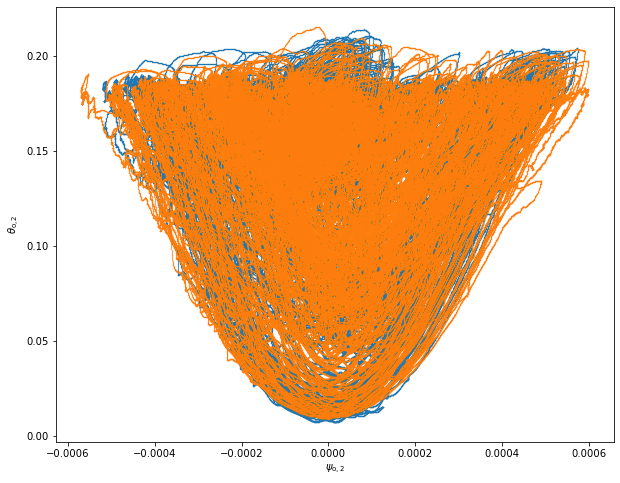

In [22]:
varx = 21
vary = 29
plt.figure(figsize=(10, 8))

plt.plot(traj[:, varx].T, traj[:, vary].T, marker='o', ms=0.1, ls='')

plt.xlabel('$'+model_parameters.latex_var_string[varx]+'$')
plt.ylabel('$'+model_parameters.latex_var_string[vary]+'$');

Plot of the variables $\theta_{{\rm a}, 1}$, $\psi_{{\rm o}, 2}$, $\theta_{{\rm o}, 2}$ and $(x+y)$ versus the time for the first and second trajectories

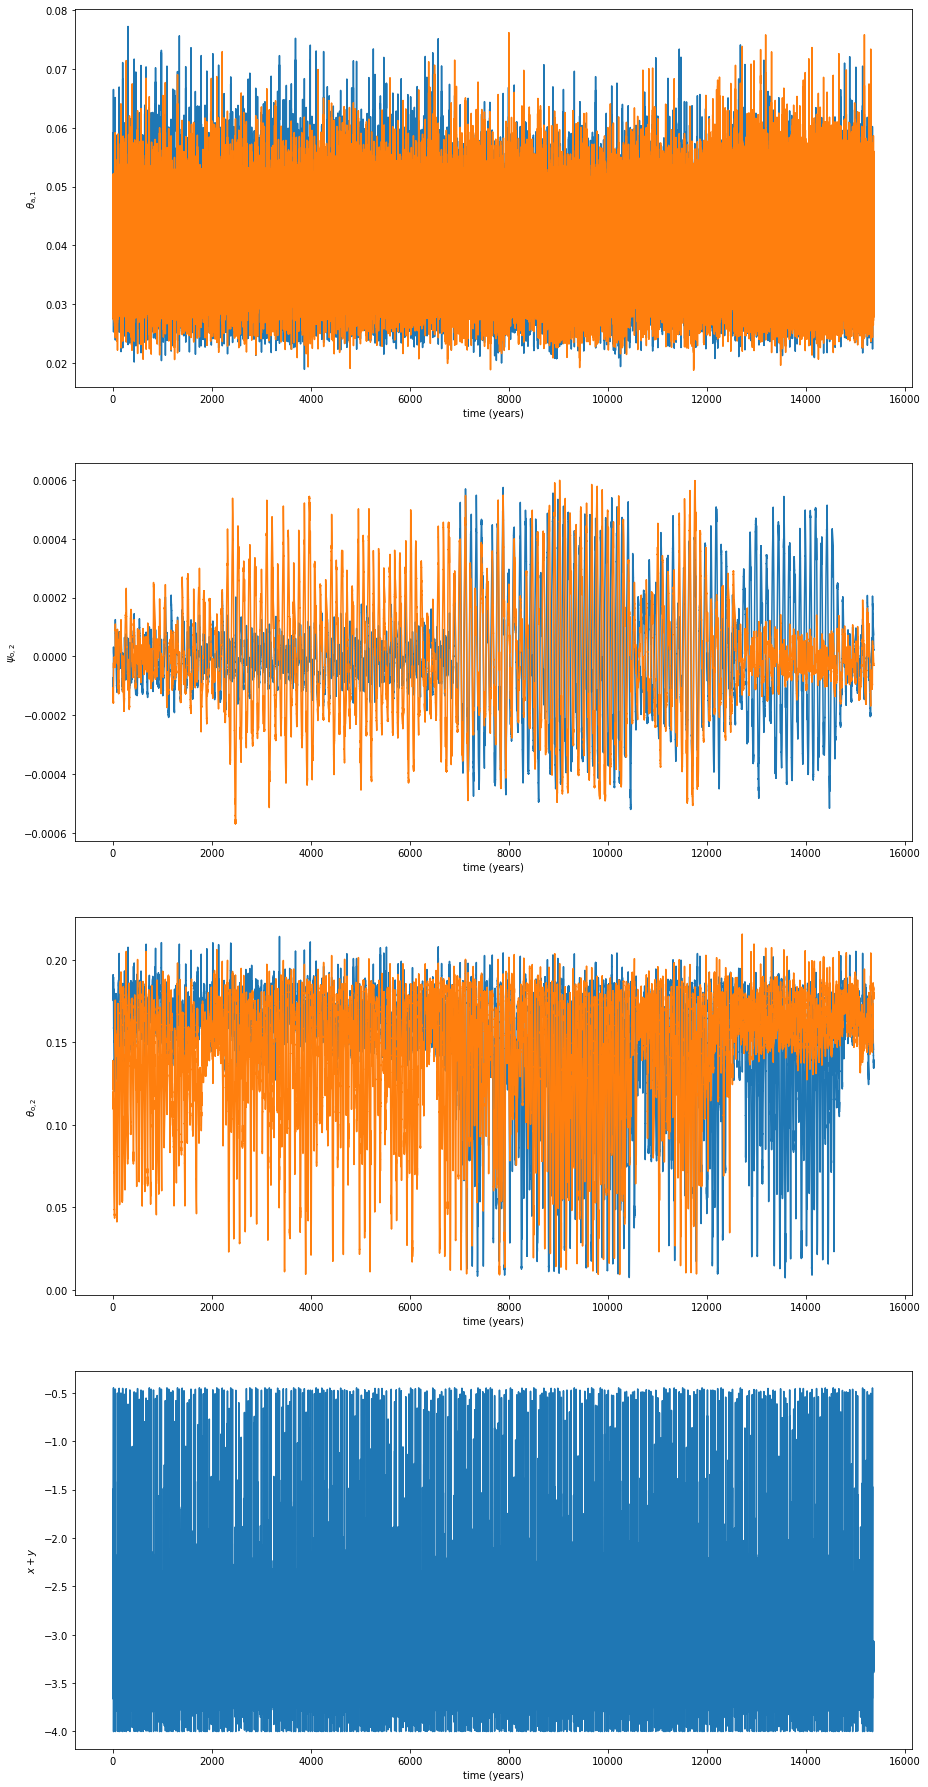

In [23]:
var1 = 10
var2 = 21
var3 = 29
plt.figure(figsize=(15, 32))

plt.subplot(4,1,1)
for nt in range(number_of_trajectories):
    plt.plot(model_parameters.dimensional_time*time, traj[nt, var1])
plt.xlabel('time (years)')
plt.ylabel('$'+model_parameters.latex_var_string[var1]+'$');

plt.subplot(4,1,2)
for nt in range(number_of_trajectories):
    plt.plot(model_parameters.dimensional_time*time, traj[nt, var2])
plt.xlabel('time (years)')
plt.ylabel('$'+model_parameters.latex_var_string[var2]+'$');

plt.subplot(4,1,3)
for nt in range(number_of_trajectories):
    plt.plot(model_parameters.dimensional_time*time, traj[nt, var3])
plt.xlabel('time (years)')
plt.ylabel('$'+model_parameters.latex_var_string[var3]+'$');

plt.subplot(4,1,4)
plt.plot(model_parameters.dimensional_time*time, traj[0, 36] + traj[0, 37])
plt.xlabel('time (years)')
plt.ylabel('$x + y$');